In [ ]:
#Завдання 3 --------------------------------------------------------------

In [ ]:
# Задача класифікації текстів за допомогою рекурентної нейромережі.
# https://www.kaggle.com/datasets/tafadzwaz/emotion-classify-data

In [39]:
import pandas as pd
import string
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt

# Завантаження даних
data = pd.read_csv('Emotion_classify_Data.csv', encoding='latin-1')

# Очищення тексту
def cleaning(value):
    punctuation_cleaning = []
    stopwords_cleaning_string = ''
    
    for i in value:
        if i not in string.punctuation:
            punctuation_cleaning.append(i)
    punctuation_cleaning = "".join(punctuation_cleaning).split()
    
    # Видалення стоп-слів (з використанням свого списку)
    stopwords_list = ["a", "an", "the", "in", "on", "at", "is", "it", "and", "to", "of"]
    for j in punctuation_cleaning:
        if j.lower() not in stopwords_list:
            stopwords_cleaning_string += j.lower() + ' '
    
    return stopwords_cleaning_string

data['Cleaned_Comment'] = data['Comment'].apply(cleaning)

In [31]:
# Перетворення емоцій у числовий формат
label_encoder = LabelEncoder()
data['Emotion_Label'] = label_encoder.fit_transform(data['Emotion'])

In [32]:
# Розподіл даних
X = data['Cleaned_Comment']
y = data['Emotion_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, stratify=y)

In [33]:
# Токенізація тексту
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
maxlen = int(np.ceil(np.mean([len(x) for x in X_train_seq])))
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')
total_words = len(tokenizer.word_index) + 1

In [34]:
# ---- СПОСІБ 1: Навчання з нуля ---- #
print("Навчання моделі з нуля...")
model_scratch = Sequential()
model_scratch.add(Embedding(total_words, 32, input_length=maxlen))
model_scratch.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model_scratch.add(Dense(len(label_encoder.classes_), activation='softmax'))
model_scratch.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
history_scratch = model_scratch.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)


Навчання моделі з нуля...
Epoch 1/10


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3557 - loss: 1.0964 - val_accuracy: 0.5253 - val_loss: 1.0156
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5771 - loss: 0.8823 - val_accuracy: 0.5863 - val_loss: 0.7393
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6773 - loss: 0.6330 - val_accuracy: 0.5832 - val_loss: 0.7229
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6752 - loss: 0.5748 - val_accuracy: 0.6779 - val_loss: 0.7544
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7447 - loss: 0.5259 - val_accuracy: 0.6821 - val_loss: 0.7418
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7964 - loss: 0.4770 - val_accuracy: 0.7968 - val_loss: 0.6368
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8711 - loss: 0.3553 - val_accuracy: 0.8368 - val_loss: 0.5235
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9327 - loss: 0.2261 - val_accuracy: 0.8242 - val

In [41]:
# ---- СПОСІБ 2: Використання pretrained embeddings ---- #
print("Завантаження pretrained embeddings...")
embedding_dim = 50
embedding_matrix = np.zeros((total_words, embedding_dim))
# Замість GloVe, ініціалізуємо випадкові вектори для прикладу
for word, i in tokenizer.word_index.items():
    if i < total_words:
        embedding_matrix[i] = np.random.rand(embedding_dim)

Завантаження pretrained embeddings...


In [42]:
model_pretrained = Sequential()
model_pretrained.add(Embedding(
    total_words,
    embedding_dim,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=False  # Заморожуємо попередньо навчені вектори
))
model_pretrained.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model_pretrained.add(Dense(len(label_encoder.classes_), activation='softmax'))
model_pretrained.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
history_pretrained = model_pretrained.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3499 - loss: 1.1038 - val_accuracy: 0.3716 - val_loss: 1.0954
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3508 - loss: 1.0991 - val_accuracy: 0.3411 - val_loss: 1.0965
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3502 - loss: 1.0977 - val_accuracy: 0.3537 - val_loss: 1.0957
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3510 - loss: 1.0979 - val_accuracy: 0.3400 - val_loss: 1.0964
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3597 - loss: 1.0958 - val_accuracy: 0.3368 - val_loss: 1.0968
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3495 - loss: 1.0973 - val_accuracy: 0.3284 - val_loss: 1.0980
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3572 - loss: 1.0970 - val_accuracy: 0.3284 - val_loss: 1.0977
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3541 - loss: 1.0975 - val_accuracy: 0.3411 - val

In [43]:
# ---- Порівняння результатів ---- #
print("Оцінка моделі з нуля:")
results_scratch = model_scratch.evaluate(X_test_pad, y_test, verbose=0)
print(f"Loss: {results_scratch[0]}, Accuracy: {results_scratch[1]}")

print("Оцінка моделі з pretrained embeddings:")
results_pretrained = model_pretrained.evaluate(X_test_pad, y_test, verbose=0)
print(f"Loss: {results_pretrained[0]}, Accuracy: {results_pretrained[1]}")


Оцінка моделі з нуля:
Loss: 0.5160289406776428, Accuracy: 0.8417508602142334
Оцінка моделі з pretrained embeddings:
Loss: 1.1001427173614502, Accuracy: 0.3308080732822418


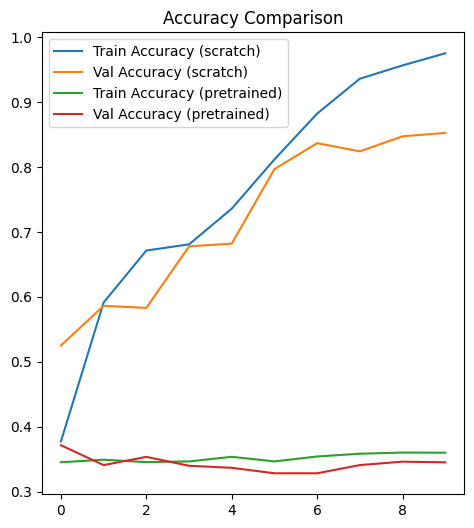

In [44]:
# ---- Візуалізація результатів ---- #
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_scratch.history['accuracy'], label='Train Accuracy (scratch)')
plt.plot(history_scratch.history['val_accuracy'], label='Val Accuracy (scratch)')
plt.plot(history_pretrained.history['accuracy'], label='Train Accuracy (pretrained)')
plt.plot(history_pretrained.history['val_accuracy'], label='Val Accuracy (pretrained)')
plt.title('Accuracy Comparison')
plt.legend()

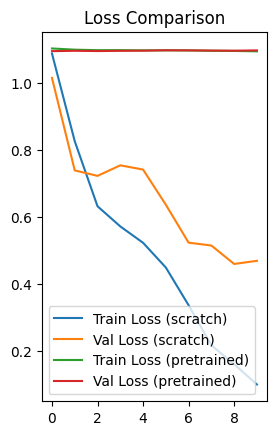

In [45]:
plt.subplot(1, 2, 2)
plt.plot(history_scratch.history['loss'], label='Train Loss (scratch)')
plt.plot(history_scratch.history['val_loss'], label='Val Loss (scratch)')
plt.plot(history_pretrained.history['loss'], label='Train Loss (pretrained)')
plt.plot(history_pretrained.history['val_loss'], label='Val Loss (pretrained)')
plt.title('Loss Comparison')
plt.legend()

plt.show()